<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверим-на-адекватность" data-toc-modified-id="Проверим-на-адекватность-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверим на адекватность</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn 

from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score


from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import catboost as cat
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
data = data.set_index('datetime')

In [6]:
data.sort_index(inplace=True)

In [7]:
data = data.resample('1H').sum()

In [8]:
data.index.is_monotonic

True

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Ресемплировал данные и расположил в хронологическом порядке

## Анализ

<AxesSubplot:xlabel='datetime'>

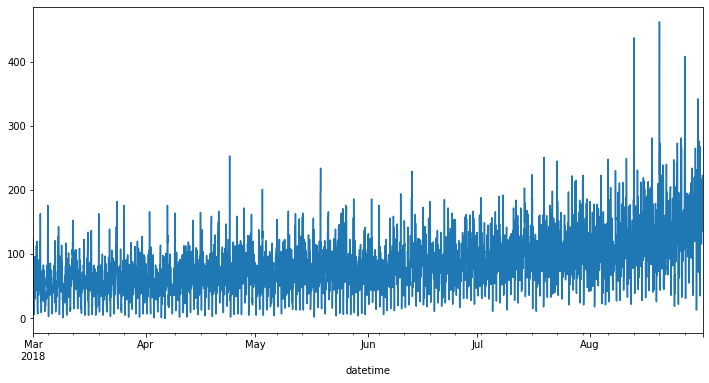

In [10]:
data['num_orders'].plot(figsize=(12,6))

Как и в тренажере, изначальный график не поддается анализу. Найдем скользящее среднее.

In [11]:
new_data = data.copy()
new_data = new_data.resample('1H').sum()
new_data['roll_mean'] = new_data['num_orders'].shift().rolling(12).mean()
new_data['std_div'] = new_data['num_orders'].rolling(12).std()
new_data = new_data.dropna()

<AxesSubplot:xlabel='datetime'>

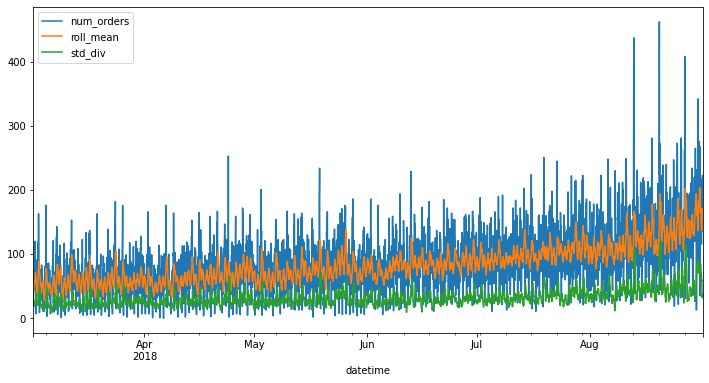

In [12]:
new_data[['num_orders', 'roll_mean', 'std_div']].plot(figsize=(12,6))

In [13]:
print('Start date:', data.index.min())
print('End date:', data.index.max())
print('Total time:', data.index.max() - data.index.min())
print()
data.describe()

Start date: 2018-03-01 00:00:00
End date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


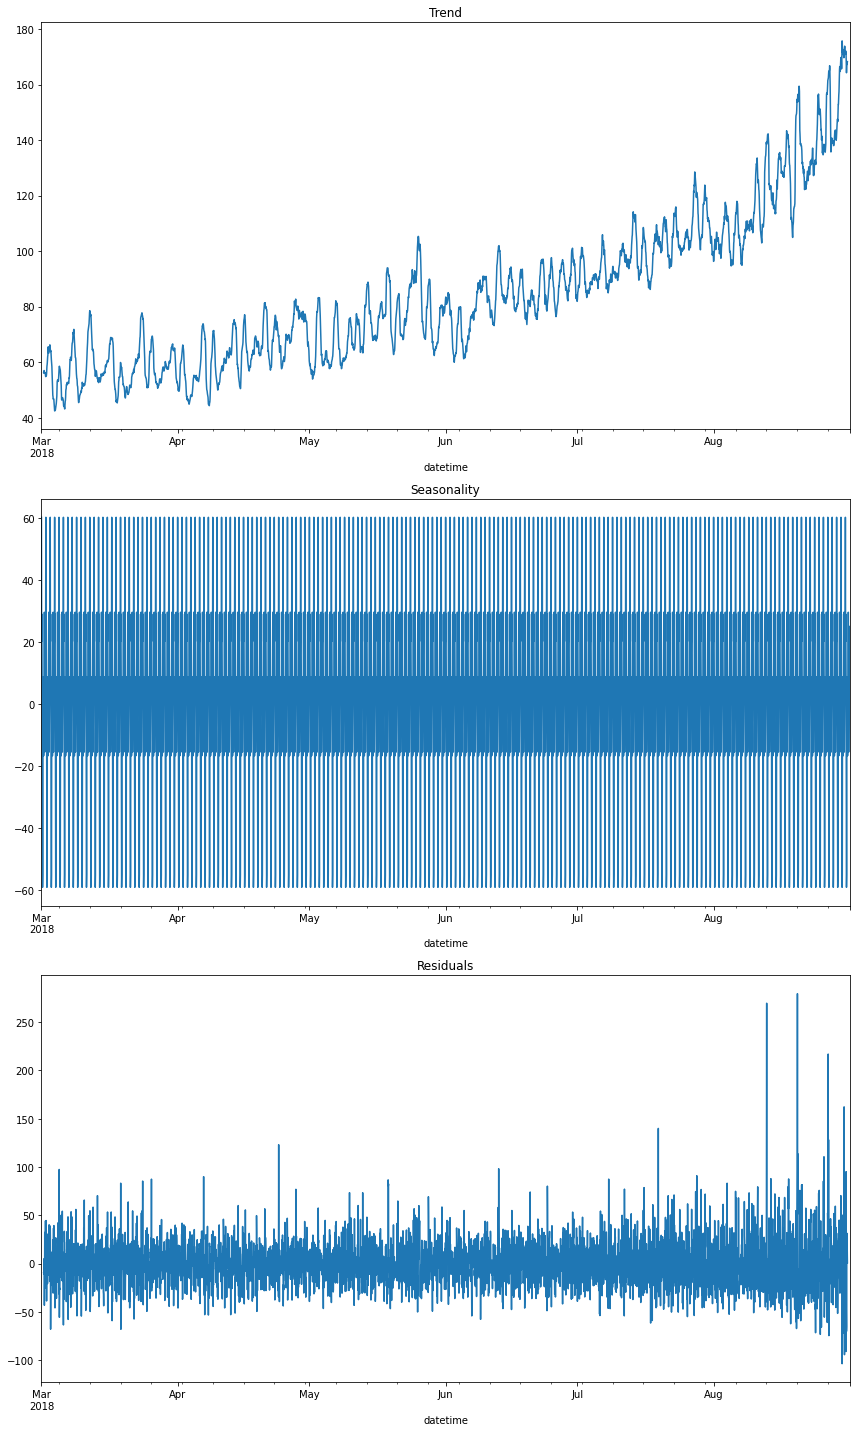

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(3, 1, 1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(3, 1, 2)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(3, 1, 3)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Чтобы понять детальнее, уменьшим интервал 

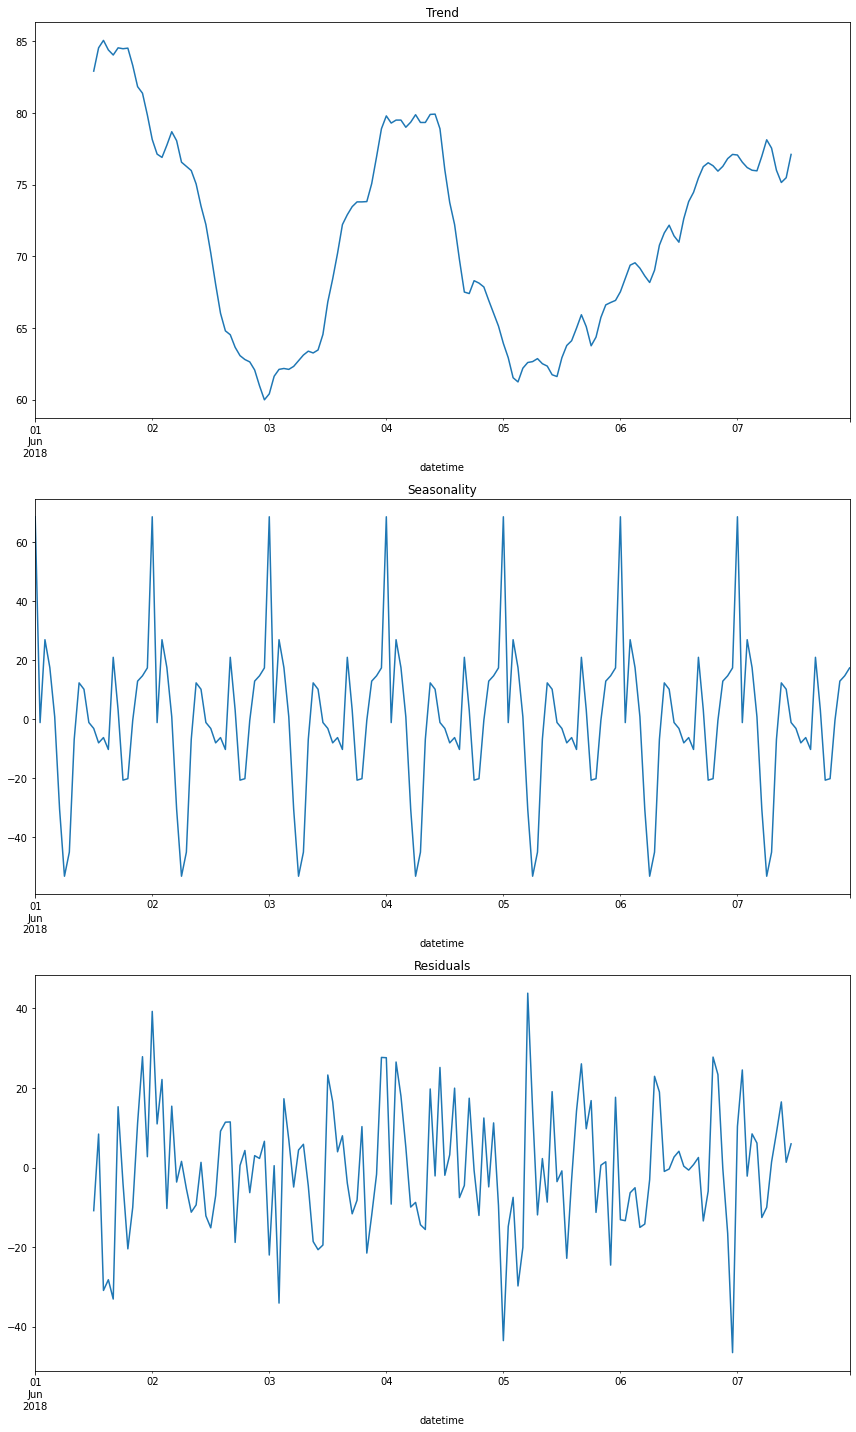

In [15]:
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(3, 1, 1)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(3, 1, 2)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(3, 1, 3)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По ночам, кол-во заказов стримится к нулю. Перед этим, час пик, когда все возвращаются домой с работы.

<AxesSubplot:xlabel='datetime'>

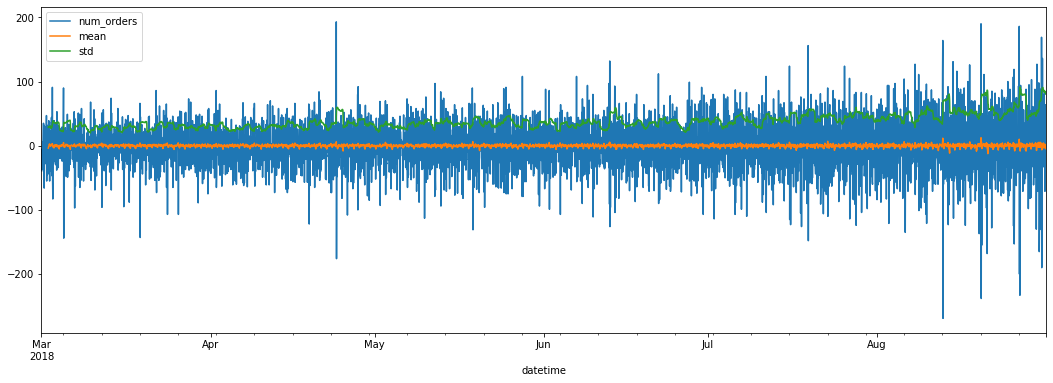

In [16]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=(18, 6))

На графике, после декомпозиции, видно, что тренд на заказы такси в течение часа растет. Т.к. у нас данные только за 184 неполных дня, мы не можем утверждать, что это связано с ростом компании или с месячной сезонностью, для этого нужны данные за несколько лет. На графиках есть суточная сезонность, ночью заказов практически нет, перед этим скачек в кол-ве заказов "час пик" вечернего времени, предположительно, когда все возвращаются домой с работы.

## Обучение

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df = df.dropna()

In [18]:
make_features(data, 24, 100)

In [19]:
data = data.dropna()
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [21]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [22]:
%%time

forest_cv = TimeSeriesSplit(n_splits=3).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=forest_cv)
forest_grid.fit(features_train, target_train)

CPU times: user 3min 25s, sys: 323 ms, total: 3min 25s
Wall time: 3min 26s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f7a8695a3c0>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [ ]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)

In [24]:
%%time
LR_cv = TimeSeriesSplit(n_splits=3).split(features_train)

regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

regression.fit(features_train, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=LR_cv)).mean()*(-1)
print('Среднее качество на кросс-валидации:', regression_cv_score)

Среднее качество на кросс-валидации: 28.412402437142486
CPU times: user 58 ms, sys: 308 ms, total: 366 ms
Wall time: 320 ms


In [25]:
%%time

cat_cv = TimeSeriesSplit(n_splits=3).split(features_train)

cb = cat.CatBoostRegressor()

cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=cat_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8427470	total: 48.1ms	remaining: 48.1s
100:	learn: 17.8692599	total: 177ms	remaining: 1.57s
200:	learn: 15.9607824	total: 308ms	remaining: 1.22s
300:	learn: 14.7128169	total: 433ms	remaining: 1s
400:	learn: 13.5776480	total: 565ms	remaining: 843ms
500:	learn: 12.6540101	total: 695ms	remaining: 692ms
600:	learn: 11.7146676	total: 836ms	remaining: 555ms
700:	learn: 10.9266052	total: 973ms	remaining: 415ms
800:	learn: 10.2835647	total: 1.11s	remaining: 276ms
900:	learn: 9.6413875	total: 1.24s	remaining: 136ms
999:	learn: 9.0798153	total: 1.36s	remaining: 0us
0:	learn: 31.8817805	total: 2.4ms	remaining: 2.4s
100:	learn: 20.1994746	total: 173ms	remaining: 1.54s
200:	learn: 18.5270027	total: 333ms	remaining: 1.32s
300:	learn: 17.4868682	total: 496ms	remaining: 1.15s
400:	learn: 16.5724681	total: 657ms	remaining: 982ms
500:	learn: 15.8557860	total: 821ms	remaining: 817ms
600:	learn: 15.2104647	total: 986ms	remaining: 654ms
700:	learn: 14.6605748	total: 1.15s	remaining: 490ms
800:

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f7a86c21ba0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7a86c14ac0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [26]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_train, target_train) * (-1)
print(cb_params)
print(cb_score)

{'depth': 4, 'learning_rate': 0.03}
17.416309815339226
CPU times: user 6.04 ms, sys: 7 µs, total: 6.04 ms
Wall time: 4.97 ms


## Тестирование

### Проверим на адекватность

In [27]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE для проверки модели на адекватность: 59.157


In [28]:
%%time

regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)


regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 45.174
CPU times: user 23.1 ms, sys: 68 ms, total: 91.1 ms
Wall time: 15.5 ms


In [29]:
def graph_compare(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))

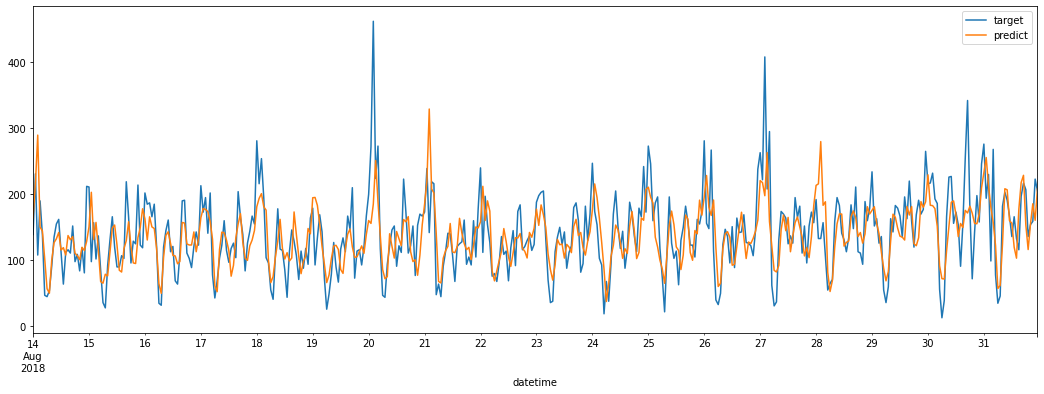

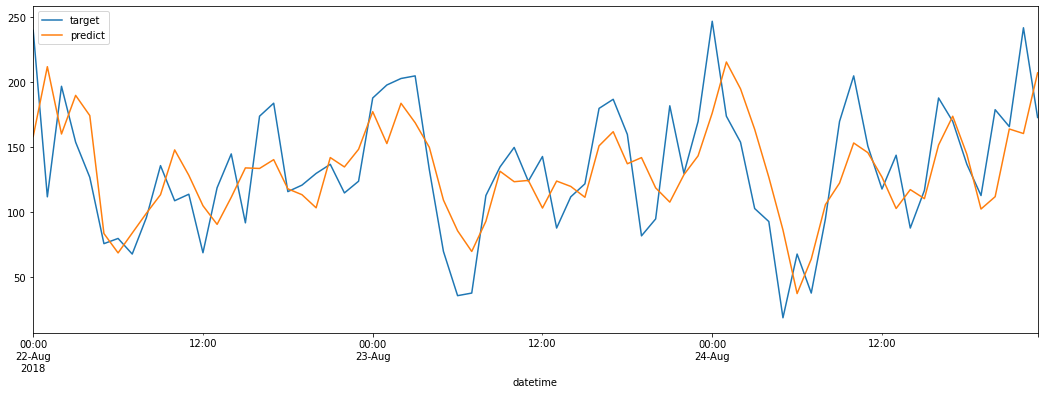

In [30]:
graph_compare(regression_model_predictions)

In [31]:
%%time

forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)


forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 44.12
CPU times: user 904 ms, sys: 0 ns, total: 904 ms
Wall time: 917 ms


In [32]:
#Функцию для построения графика важности признаков, она будет показывать только те признаки, важность которых больше 0.0
def feature_search(model, features_train):
    importances = list(model.feature_importances_)
    names_indices = features_train.columns
    not_null_importances = []
    not_null_indices = []

    for i in importances:
        if i > 0:
            not_null_importances.append(i)
            not_null_indices.append(names_indices[importances.index(i)])
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature importances")
 
    plt.bar(range(len(not_null_importances)), not_null_importances, color="r")
    plt.xticks(range(len(importances)), not_null_indices, rotation=90)
 
    plt.tight_layout()
    plt.xlim([-1, len(not_null_importances)])
    plt.show()

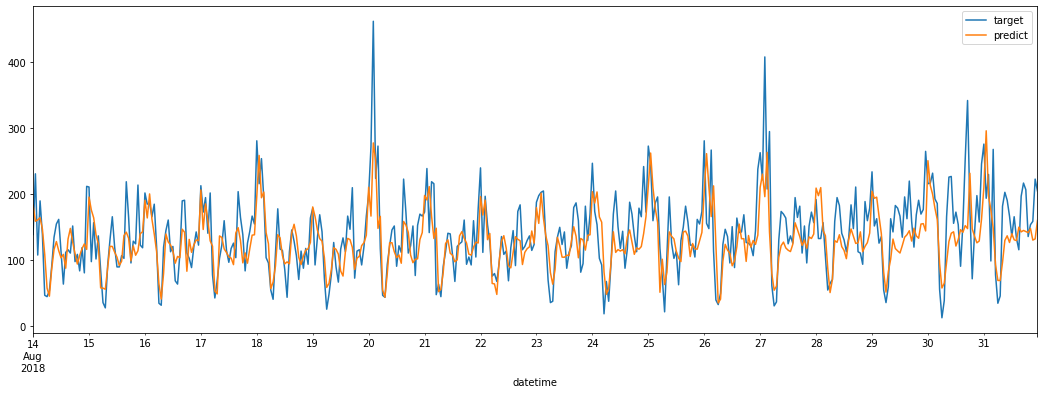

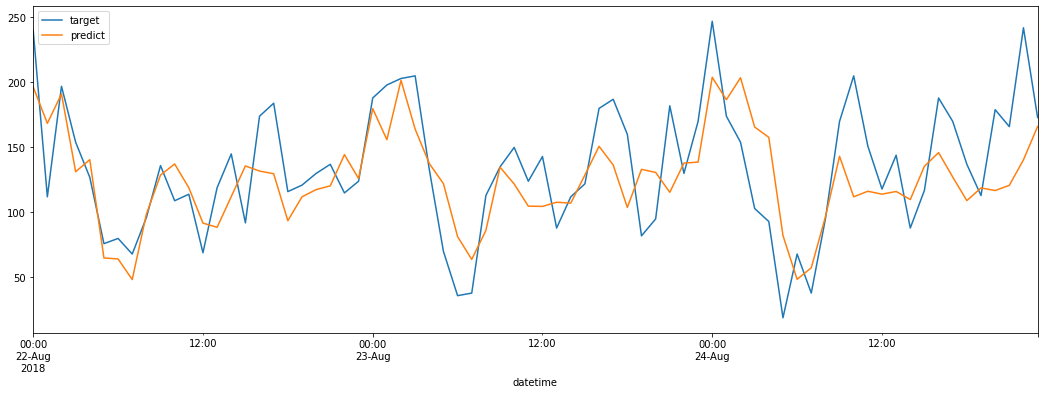

In [33]:
graph_compare(forest_model_predictions)

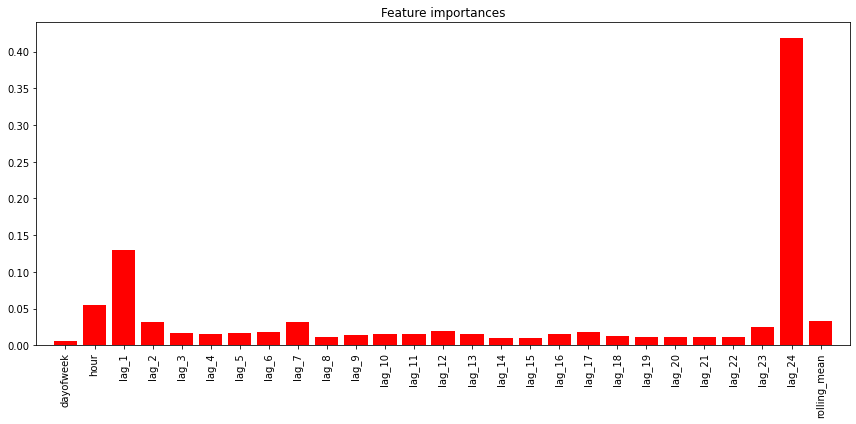

In [34]:
feature_search(forest_model, features_train)

In [35]:
%%time


cb_model = cat.CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)


cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

0:	learn: 38.2170015	total: 2.45ms	remaining: 2.44s
100:	learn: 24.2674485	total: 219ms	remaining: 1.95s
200:	learn: 22.7692978	total: 433ms	remaining: 1.72s
300:	learn: 21.7085475	total: 657ms	remaining: 1.52s
400:	learn: 20.7832879	total: 879ms	remaining: 1.31s
500:	learn: 19.9726626	total: 1.18s	remaining: 1.17s
600:	learn: 19.3182983	total: 1.4s	remaining: 932ms
700:	learn: 18.7501925	total: 1.62s	remaining: 692ms
800:	learn: 18.2674206	total: 1.83s	remaining: 456ms
900:	learn: 17.8233171	total: 2.05s	remaining: 225ms
999:	learn: 17.4163098	total: 2.26s	remaining: 0us
RMSE модели CatBoostRegressor: 40.665
CPU times: user 2.32 s, sys: 88.5 ms, total: 2.41 s
Wall time: 3.21 s


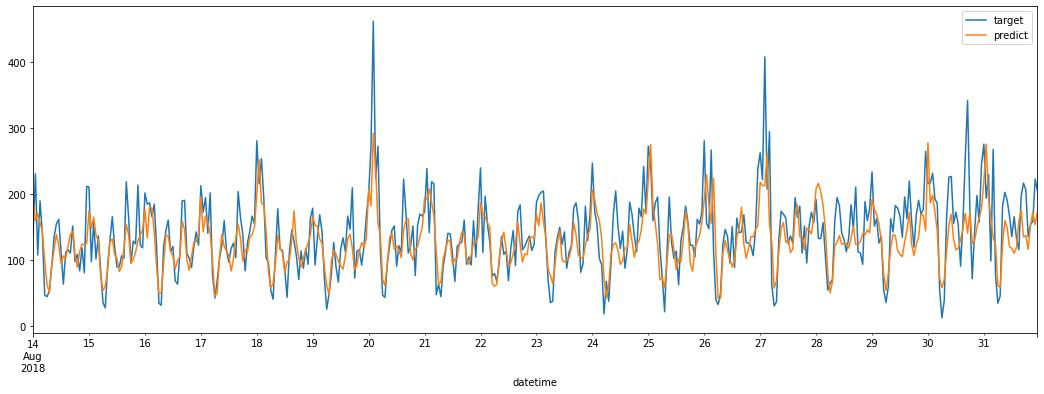

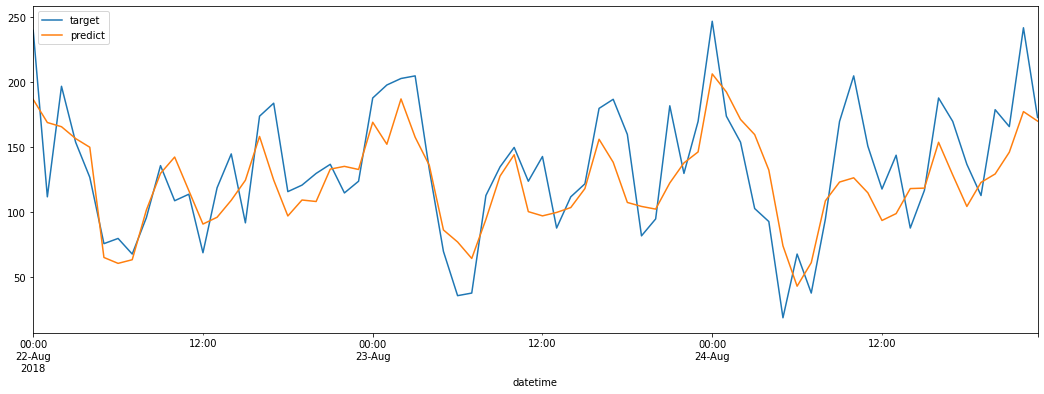

In [36]:
graph_compare(cb_model_predictions)

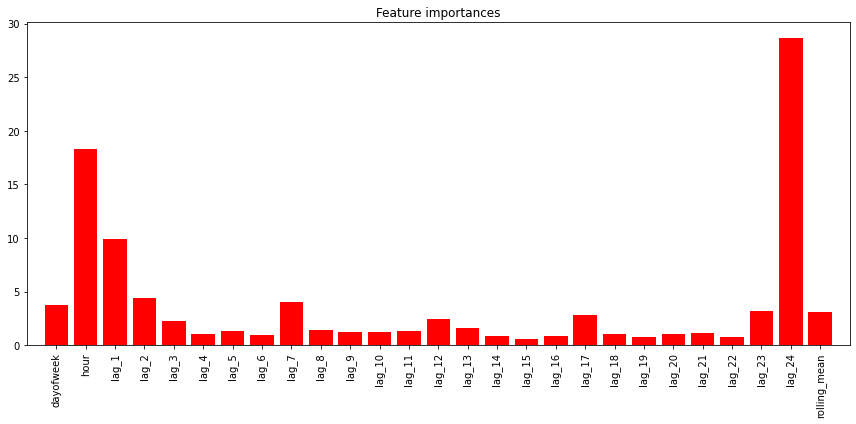

In [37]:
feature_search(cb_model, features_train)

In [38]:
print('RMSE модели CatBoostRegressor:', cb_RMSE)
print('RMSE модели Линейной регрессии:', regression_RMSE)
print('RMSE модели Случайного леса:', forest_RMSE)
print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))

RMSE модели CatBoostRegressor: 40.665
RMSE модели Линейной регрессии: 45.174
RMSE модели Случайного леса: 44.12
RMSE для проверки модели на адекватность: 59.157


Лучший показатель RMSE у CatBoostRegressor, у нее он самый низкий. 

## Вывод

В ходе работы загрузил и подготовил данные для обучения моделей.      
В данных заметен тренд увеличения заказов, который тяжело объяснить, располагая таким объемом данных. На графиках видна суточная сезонность с пиками 
в вечернее время, предположительно, когда все возвращаются с работы, и падение активности ночью.      
Проверил и протестировал несколько моделей, лучшей из которых оказался CatBoostRegressor. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48